# EEG bandpower

This notebook demonstrates how to use YASA to calculate the spectral bandpower per channel and per sleep stage.

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In [1]:
import mne
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.2)

## Data loading

### EEG data

Let's load ~45 min of mid-afternoon nap data (6 channels), sampled at 100 Hz. We use the [MNE library](https://mne.tools/stable/index.html), which includes various functions and utilities for reading EEG data and electrode locations. For a description of all the file formats supported by MNE, please refer to https://mne.tools/stable/manual/io.html#importing-data-from-eeg-devices

Note that during loading, [MNE automatically scale the EEG data from microVolts (uV) to Volts](https://martinos.org/mne/dev/manual/io.html#id3). However, YASA requires the data to be in microVolts (uV), and therefore we need to reverse this scaling by multiplying our data by 1e6 (1 V = 1,000,000 uV).

In [2]:
# Load data as a MNE Raw file
raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True, verbose=0)

# Keep only the EEG channels
raw.pick_types(eeg=True)

# Apply a bandpass filter between 0.5 - 45 Hz
raw.filter(0.5, 45)

# Extract the data and convert from V to uV
data = raw._data * 1e6
sf = raw.info['sfreq']
chan = raw.ch_names

# Let's have a look at the data
print('Chan =', chan)
print('Sampling frequency =', sf, 'Hz')
print('Data shape =', data.shape)

Chan = ['F3', 'F4', 'C3', 'C4', 'O1', 'O2']
Sampling frequency = 100.0 Hz
Data shape = (6, 294000)


### Hypnogram

Let's now load the corresponding hypnogram (sleep staging) vector. In this case, the hypnogram is a simple text file in which one value represents 30 seconds of EEG data.

The sleep stages are defined according to the [standard guidelines](https://aasm.org/clinical-resources/scoring-manual/):

    W: Wake
    N1: N1 sleep
    N2: N2 sleep
    N3: N3 sleep
    R: REM sleep

In [3]:
hypno = np.loadtxt('sub-02_hypno_30s.txt', dtype=str)
hypno

array(['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'N1', 'W', 'W', 'W',
       'W', 'N1', 'N1', 'N1', 'W', 'W', 'N1', 'N1', 'N1', 'N1', 'N2',
       'N2', 'N2', 'W', 'N1', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N3',
       'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3',
       'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'W',
       'W', 'W', 'W', 'W', 'W', 'W'], dtype='<U2')

**Conversion str => int**

Our first step is to convert this text vector into a vector of integers, which is easier to work with. The default mapping is defined below:

    W  => 0
    N1 => 1
    N2 => 2
    N3 => 3
    R  => 4
    
However, you can also apply a custom mapping using the `mapping_dict=` argument of the [hypno_str_to_int](https://raphaelvallat.com/yasa/build/html/generated/yasa.hypno_str_to_int.html#yasa.hypno_str_to_int) function.

In [4]:
hypno_int = yasa.hypno_str_to_int(hypno)
hypno_int

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 2, 2, 0, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

**Upsampling**

The last step is to upsample our hypnogram to the sampling frequency of the data. This step is *absolutely critical* and all YASA's function require that the data and hypnogram have the same sampling frequency and shape -- which makes life so much easier to mask and select specific sleep stages.

Fortunately, YASA also provides a convenient function ([hypno_upsample_to_data](https://raphaelvallat.com/yasa/build/html/generated/yasa.hypno_upsample_to_data.html#yasa.hypno_upsample_to_data)) to automatically upsample and fit the hypnogram to a given sampling frequency and data length.
This function requires the hypnogram and its sampling frequency, as well as the data and its sampling frequency. In our case, the sampling frequency of our hypnogram is 1 / 30 since there is one point per every 30 seconds of data. The sampling frequency of the data is 100 Hz.

Note that if the upsampled hypnogram is shorter or longer than the length of data, a warning will be displayed and the hypnogram will be automatically padded or cropped to exactly match the length of data.

In [5]:
hypno_up = yasa.hypno_upsample_to_data(hypno=hypno_int, sf_hypno=(1/30), data=data, sf_data=sf)
print(hypno_up.size == data.shape[1])  # Does the hypnogram have the same number of samples as data?
print(hypno_up.size, 'samples:', hypno_up)

True
294000 samples: [0 0 0 ... 0 0 0]


**************

## Bandpowers in NREM sleep

*For a primer on EEG spectral bandpower please refer to https://raphaelvallat.com/bandpower.html*

Now that we have our data and hypnogram, how can we calculate the spectral bandpowers in, let's say, N2 and N3 sleep (commonly referred to as NREM sleep)?

### Keep only N2 + N3 sleep

Our first step is to apply a masking on the data to only keep samples that are in N2 or N3 sleep. Since our data and hypnogram now have the same sampling frequency and shape, this can be done using a [simple NumPy indexing](https://docs.scipy.org/doc/numpy/reference/generated/numpy.isin.html):

In [6]:
where_NREM = np.isin(hypno_up, [2, 3])  # True if sample is in N2 / N3, False otherwise
data_NREM = data[:, where_NREM]
print(data_NREM.shape)

(6, 159000)


### Calculate Welch's PSD

The gold-standard and most widely-used method to calculate the power spectral density (PSD) of EEG data is the [Welch's sliding periodogram](https://en.wikipedia.org/wiki/Welch%27s_method), which is implemented in [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html).

The Welch's method improves the accuracy of the [classic periodogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html). The reason is simple: EEG data are always time-varying, meaning that if you look at a 30 seconds of EEG data, it is very (very) unlikely that the signal will looks like a perfect sum of pure sines. Rather, the spectral content of the EEG changes over time, constantly modified by the neuronal activity at play under the scalp. Problem is, to return a true spectral estimate, a classic periodogram requires the spectral content of the signal to be stationnary (i.e. time-unvarying) over the time period considered. Because it is never the case, the periodogram is generally biased and contains way too much variance. By averaging the periodograms obtained over short segments of the windows, the Welch's method allows to drastically reduce this variance. This comes at the cost, however, of a lower frequency resolution. The frequency resolution in Welch's method is defined by the window length, such that $F = 1 / t$, with $t$ being the window length in seconds. In other words, a 4-sec sliding window will give a frequency resolution of 1 / 4 = 0.25 Hz.

How do we define the optimal window duration then? A commonly used approach is to take a window sufficiently long to encompasses at least two full cycles of the lowest frequency of interest. So for instance, if our lowest frequency of interest is 1 Hz so we will choose a window of 2 / 1 = 2 seconds.

Note that in the code below, I use a *median average* of all the resulting sliding windows. Indeed, this may result in less biased and more accurate PSD as explained [in this paper](https://www.biorxiv.org/content/10.1101/441626v2).

(201,) (6, 201)


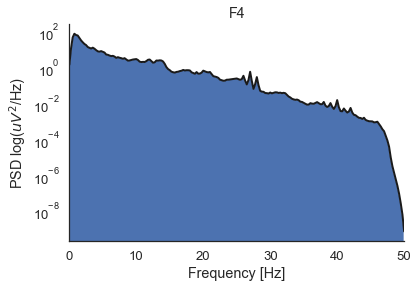

In [7]:
from scipy.signal import welch

win = int(4 * sf)  # Window size is set to 4 seconds
freqs, psd = welch(data_NREM, sf, nperseg=win, average='median')  # Works with single or multi-channel data

print(freqs.shape, psd.shape)  # psd has shape (n_channels, n_frequencies)

# Plot
plt.plot(freqs, psd[1], 'k', lw=2)
plt.fill_between(freqs, psd[1], cmap='Spectral')
plt.xlim(0, 50)
plt.yscale('log')
sns.despine()
plt.title(chan[1])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD log($uV^2$/Hz)');

### Extract bandpower

Now that we have the PSD for each channel, we need to calculate the average power in specified bands. The power in a frequency band is defined by the area under the curve of the non-log-transformed PSD. For more details, please refer to https://raphaelvallat.com/bandpower.html.

Here again, YASA provides a convenient function ([bandpower_from_psd](https://raphaelvallat.com/yasa/build/html/generated/yasa.bandpower_from_psd.html#yasa.bandpower_from_psd)) to extract the average bandpower in specified bands from a pre-computed PSD.

**Relative power**

Note that the `TotalAbsPow` column contains the total absolute (physical) power, summed across all bands.

In [8]:
# Relative power: sum of all (non-overlapping and sequential) bands equals to 1
yasa.bandpower_from_psd(psd, freqs, ch_names=chan)

,Chan,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
0,F3,0.714872,0.166226,0.070516,0.037181,0.010598,0.000607,171.857703,0.25,True
1,F4,0.719722,0.140793,0.066615,0.041250,0.030450,0.001170,148.775375,0.25,True
2,C3,0.708896,0.151639,0.079097,0.046435,0.013303,0.000629,135.059684,0.25,True
3,C4,0.678407,0.137858,0.081388,0.055760,0.044579,0.002008,122.226789,0.25,True
4,O1,0.664873,0.151314,0.101223,0.068387,0.013804,0.000399,769.863787,0.25,True
5,O2,0.663774,0.157096,0.094293,0.066035,0.018334,0.000468,670.168631,0.25,True


**Absolute power**

In [9]:
# Absolute power, using different bands
bp = yasa.bandpower_from_psd(psd, freqs, ch_names=chan, bands=[(1, 12, 'Slow'), (12, 30, 'Beta')], relative=False)
print(bp.bands_)  # Tip: see the frequency bands that were used
bp

[(1, 12, 'Slow'), (12, 30, 'Beta')]


,Chan,Slow,Beta,TotalAbsPow,FreqRes,Relative
0,F3,118.157078,8.211144,126.368222,0.25,False
1,F4,104.003894,10.667229,114.671123,0.25,False
2,C3,95.300966,8.068256,103.369221,0.25,False
3,C4,84.098698,12.264104,96.362801,0.25,False
4,O1,522.730225,63.275577,586.005802,0.25,False
5,O2,460.613075,56.541394,517.154469,0.25,False


***********************

## A one-liner function

The above is great, but calculating the hypnogram mask and the PSD of data manually every time seems a bit tedious. Can we wrap all that into a single function? The good news is that, yes, you can directly apply the [bandpower](https://raphaelvallat.com/yasa/build/html/generated/yasa.bandpower.html#yasa.bandpower) function to raw EEG data (in numpy or MNE format), which will automatically run all the previous steps for you. In other words, the function will:

1. Calculate an hypnogram mask, if wanted
2. Calculate the Welch's PSD for each channel, and, if applicable, each sleep stage
3. Return the bandpowers as a single dataframe.

Let's see some example below.

**Working with NumPy array**

In [10]:
# Relative bandpower per channel on the whole recording (entire data)
yasa.bandpower(data, sf=sf, ch_names=chan)

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,,,
F3,0.636693,0.202645,0.103551,0.038842,0.017315,0.000954,127.618684,0.25,True
F4,0.632714,0.167312,0.102019,0.050122,0.046038,0.001794,116.091721,0.25,True
C3,0.553818,0.203048,0.157099,0.059053,0.025890,0.001091,98.111686,0.25,True
C4,0.550775,0.164835,0.148458,0.071653,0.061851,0.002427,98.797977,0.25,True
O1,0.530968,0.193649,0.176263,0.076812,0.021669,0.000639,594.933458,0.25,True
O2,0.507774,0.197531,0.182381,0.081835,0.029632,0.000847,490.549941,0.25,True


In [11]:
# Same but after applying a FIR bandpass-filter
# The frequencies are defined as the lowest and highest frequencies in bands, 
# respectively (default 0.5 to 40 hz)
yasa.bandpower(data, sf=sf, ch_names=chan)

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,,,
F3,0.636693,0.202645,0.103551,0.038842,0.017315,0.000954,127.618684,0.25,True
F4,0.632714,0.167312,0.102019,0.050122,0.046038,0.001794,116.091721,0.25,True
C3,0.553818,0.203048,0.157099,0.059053,0.025890,0.001091,98.111686,0.25,True
C4,0.550775,0.164835,0.148458,0.071653,0.061851,0.002427,98.797977,0.25,True
O1,0.530968,0.193649,0.176263,0.076812,0.021669,0.000639,594.933458,0.25,True
O2,0.507774,0.197531,0.182381,0.081835,0.029632,0.000847,490.549941,0.25,True


In [12]:
# Relative bandpower per channel, for N2 and N3 sleep separately
yasa.bandpower(data, sf=sf, ch_names=chan, hypno=hypno_up, include=(2, 3))

Delta     Theta     Alpha     Sigma      Beta     Gamma  \
Stage Chan                                                               
2     F3    0.627304  0.203762  0.093739  0.058738  0.015560  0.000897   
      F4    0.633748  0.164128  0.089177  0.068108  0.043197  0.001643   
      C3    0.620138  0.174503  0.109323  0.075471  0.019631  0.000934   
      C4    0.589504  0.152978  0.108081  0.086052  0.060613  0.002772   
      O1    0.565617  0.189377  0.131287  0.094629  0.018514  0.000576   
      O2    0.555877  0.199497  0.125399  0.093607  0.024931  0.000689   
3     F3    0.828649  0.108011  0.040972  0.016952  0.005122  0.000295   
      F4    0.838153  0.092264  0.036461  0.017440  0.015089  0.000593   
      C3    0.821808  0.106564  0.043543  0.021145  0.006622  0.000318   
      C4    0.803859  0.101670  0.044725  0.025314  0.023397  0.001035   
      O1    0.796031  0.096900  0.061064  0.037892  0.007899  0.000214   
      O2    0.796404  0.102136  0.055112  0.035793  0.010317  0.000238   

            TotalAbsPow  FreqRes  Relative  
Stage Chan                                  
2     F3     120.004204     0.25      True  
      F4     104.510568     0.25      True  
      C3      94.971948     0.25      True  
      C4      89.487769     0.25      True  
      O1     546.818728     0.25      True  
      O2     470.163453     0.25      True  
3     F3     342.477172     0.25      True  
      F4     300.360463     0.25      True  
      C3     257.981046     0.25      True  
      C4     233.896876     0.25      True  
      O1    1425.054797     0.25      True  
      O2    1259.005568     0.25      True

In [13]:
# Absolute bandpower using a 2-sec window
# Note that since `ch_names` is not provided, channels are simply labelled as ['CHAN001', 'CHAN002', ...]
yasa.bandpower(data, sf, win_sec=2, relative=False)

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,,,
CHAN000,76.740490,24.432611,13.039698,4.750606,2.214708,0.122448,121.382099,0.5,False
CHAN001,67.080505,18.582526,11.481893,5.574031,5.297087,0.209542,108.376150,0.5,False
CHAN002,50.195613,19.384323,15.142030,5.633680,2.532756,0.106634,93.121585,0.5,False
CHAN003,49.937619,16.107595,14.601446,6.833524,6.060415,0.236358,94.013954,0.5,False
CHAN004,289.777098,114.721895,106.985385,47.043321,12.951929,0.385445,572.312838,0.5,False
CHAN005,226.634080,96.004044,91.664759,40.414813,14.576597,0.415770,469.398404,0.5,False


**Working with MNE Raw object**

In [14]:
# We do not  need to specify the `sf` or `ch_names` since these are
# directly extracted from the MNE Raw structure
yasa.bandpower(raw, hypno=hypno_up, include=(2))

Delta     Theta     Alpha     Sigma      Beta     Gamma  \
Stage Chan                                                               
2     F3    0.627304  0.203762  0.093739  0.058738  0.015560  0.000897   
      F4    0.633748  0.164128  0.089177  0.068108  0.043197  0.001643   
      C3    0.620138  0.174503  0.109323  0.075471  0.019631  0.000934   
      C4    0.589504  0.152978  0.108081  0.086052  0.060613  0.002772   
      O1    0.565617  0.189377  0.131287  0.094629  0.018514  0.000576   
      O2    0.555877  0.199497  0.125399  0.093607  0.024931  0.000689   

            TotalAbsPow  FreqRes  Relative  
Stage Chan                                  
2     F3     120.004204     0.25      True  
      F4     104.510568     0.25      True  
      C3      94.971948     0.25      True  
      C4      89.487769     0.25      True  
      O1     546.818728     0.25      True  
      O2     470.163453     0.25      True

In [15]:
# Bandpower of the full recording
bp = yasa.bandpower(raw)
bp

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,,,
F3,0.636693,0.202645,0.103551,0.038842,0.017315,0.000954,127.618684,0.25,True
F4,0.632714,0.167312,0.102019,0.050122,0.046038,0.001794,116.091721,0.25,True
C3,0.553818,0.203048,0.157099,0.059053,0.025890,0.001091,98.111686,0.25,True
C4,0.550775,0.164835,0.148458,0.071653,0.061851,0.002427,98.797977,0.25,True
O1,0.530968,0.193649,0.176263,0.076812,0.021669,0.000639,594.933458,0.25,True
O2,0.507774,0.197531,0.182381,0.081835,0.029632,0.000847,490.549941,0.25,True


In [16]:
# We can quickly recover the physical bandpower using the `TotalAbsPow`
bands = ['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta', 'Gamma']
bp_abs = (bp[bands] * bp['TotalAbsPow'].values[..., None])
bp_abs

,Delta,Theta,Alpha,Sigma,Beta,Gamma
Chan,,,,,,
F3,81.253931,25.861325,13.215084,4.956925,2.209733,0.121686
F4,73.452884,19.423561,11.843600,5.818788,5.344603,0.208286
C3,54.336066,19.921339,15.413273,5.793817,2.540105,0.107085
C4,54.415473,16.285331,14.667380,7.079218,6.110783,0.239791
O1,315.890752,115.208012,104.864643,45.698244,12.891758,0.380050
O2,249.088677,96.898699,89.466897,40.144358,14.535813,0.415497


In [17]:
# Single channel bandpower
yasa.bandpower(raw.copy().pick_channels(['F3']), hypno=hypno_up, include=(2, 3), bandpass=True)

,,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
Stage,Chan,,,,,,,,,
2,F3,0.626938,0.204079,0.093713,0.058804,0.015568,0.000898,119.605426,0.25,True
3,F3,0.828481,0.108190,0.040935,0.016974,0.005125,0.000294,341.404619,0.25,True


In [18]:
# Alternatively, if one prefer to work with a string hypnogram
hypno_up_str = yasa.hypno_upsample_to_data(hypno=hypno, sf_hypno=(1/30), data=data, sf_data=sf)
print(np.unique(hypno_up_str))
yasa.bandpower(raw, hypno=hypno_up_str, include=('N2', 'N3'))

['N1' 'N2' 'N3' 'W']


Delta     Theta     Alpha     Sigma      Beta     Gamma  \
Stage Chan                                                               
N2    F3    0.627304  0.203762  0.093739  0.058738  0.015560  0.000897   
      F4    0.633748  0.164128  0.089177  0.068108  0.043197  0.001643   
      C3    0.620138  0.174503  0.109323  0.075471  0.019631  0.000934   
      C4    0.589504  0.152978  0.108081  0.086052  0.060613  0.002772   
      O1    0.565617  0.189377  0.131287  0.094629  0.018514  0.000576   
      O2    0.555877  0.199497  0.125399  0.093607  0.024931  0.000689   
N3    F3    0.828649  0.108011  0.040972  0.016952  0.005122  0.000295   
      F4    0.838153  0.092264  0.036461  0.017440  0.015089  0.000593   
      C3    0.821808  0.106564  0.043543  0.021145  0.006622  0.000318   
      C4    0.803859  0.101670  0.044725  0.025314  0.023397  0.001035   
      O1    0.796031  0.096900  0.061064  0.037892  0.007899  0.000214   
      O2    0.796404  0.102136  0.055112  0.035793  0.010317  0.000238   

            TotalAbsPow  FreqRes  Relative  
Stage Chan                                  
N2    F3     120.004204     0.25      True  
      F4     104.510568     0.25      True  
      C3      94.971948     0.25      True  
      C4      89.487769     0.25      True  
      O1     546.818728     0.25      True  
      O2     470.163453     0.25      True  
N3    F3     342.477172     0.25      True  
      F4     300.360463     0.25      True  
      C3     257.981046     0.25      True  
      C4     233.896876     0.25      True  
      O1    1425.054797     0.25      True  
      O2    1259.005568     0.25      True

***********************

## To higher dimensions and beyond!

Now, let's say that we're working with higher dimensions of data, such as for example a 3-D array of shape `(n_epochs, n_chan, n_samples)`. For instance, this can be the case if you use the [yasa.sliding_window](https://raphaelvallat.com/yasa/build/html/generated/yasa.sliding_window.html) function to segment 2-D data into 30-seconds epochs, as illustrated below.

In [19]:
# Create a 3-D array
data = raw.get_data() * 1e6
sf = raw.info['sfreq']

_, data = yasa.sliding_window(data, sf, window=30)

print(raw.ch_names)
print(data.shape, sf)

['F3', 'F4', 'C3', 'C4', 'O1', 'O2']
(98, 6, 3000) 100.0


* The first dimension of ``data`` corresponds to the 98 epochs that were extracted from the data using the [yasa.sliding_window](https://raphaelvallat.com/yasa/build/html/generated/yasa.sliding_window.html) function.
* The second dimension is the 6 channels.
* The last dimension refers to the number of samples present in each window (30-seconds @ 100 Hz: 3000 data points).

This type of multi-dimensional data does not work with standard 2D tabular data, like pandas Datarame. We therefore have to use NumPy-based operations to calculate the bandpower. This can be done with the `yasa.bandpower_from_psd_ndarray` function. But first, we need to calculate the (PSD) on each epoch:

In [20]:
win = int(4 * sf)  # Window size is set to 4 seconds
freqs, psd = welch(data, sf, nperseg=win, axis=-1) 

freqs.shape, psd.shape

((201,), (98, 6, 201))

`psd` has now a shape of 98 epochs x 6 channels x 201 frequencies.

In [21]:
bands=[(0.5, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), 
       (12, 16, 'Sigma'), (16, 30, 'Beta')]

# Calculate the bandpower on 3-D PSD array
bandpower = yasa.bandpower_from_psd_ndarray(psd, freqs, bands)
np.round(bandpower, 2)

array([[[0.82, 0.85, 0.77, 0.57, 0.76, 0.44],
        [0.78, 0.7 , 0.63, 0.74, 0.77, 0.53],
        [0.53, 0.56, 0.2 , 0.23, 0.24, 0.2 ],
        ...,
        [0.63, 0.66, 0.37, 0.55, 0.56, 0.44],
        [0.1 , 0.12, 0.09, 0.08, 0.14, 0.11],
        [0.06, 0.06, 0.04, 0.03, 0.1 , 0.07]],

       [[0.13, 0.08, 0.11, 0.14, 0.11, 0.13],
        [0.12, 0.19, 0.13, 0.12, 0.07, 0.15],
        [0.22, 0.17, 0.28, 0.22, 0.21, 0.18],
        ...,
        [0.25, 0.19, 0.23, 0.16, 0.19, 0.19],
        [0.03, 0.02, 0.04, 0.02, 0.06, 0.05],
        [0.02, 0.02, 0.02, 0.01, 0.05, 0.04]],

       [[0.03, 0.03, 0.08, 0.18, 0.09, 0.33],
        [0.07, 0.08, 0.19, 0.1 , 0.13, 0.25],
        [0.19, 0.17, 0.41, 0.4 , 0.46, 0.51],
        ...,
        [0.07, 0.1 , 0.35, 0.22, 0.21, 0.32],
        [0.02, 0.01, 0.05, 0.03, 0.1 , 0.12],
        [0.01, 0.01, 0.03, 0.02, 0.09, 0.11]],

       [[0.01, 0.02, 0.02, 0.07, 0.02, 0.07],
        [0.02, 0.02, 0.03, 0.02, 0.02, 0.04],
        [0.03, 0.04, 0.06, 0.08, 0.

In [22]:
bandpower.shape

(5, 98, 6)

The shape of `bandpower` is now n_bands, n_epochs, n_chan. For example, to get the delta power on the first epoch of the first channel:

In [23]:
bandpower[0, 0, 0]

0.8175389993433952

And to get the average theta power across all epochs of the second channel:

In [24]:
bandpower.mean(axis=-2)[1, 1]

0.15169517794177534